This program will train a GRU model for multi-class classification using a custom architecture. It will train the model using PyTorch and save a checkpoint which can be used later to retreive the model and evalute it

In [50]:
import pandas as pd
import random
import torch
import seaborn as sn
import warnings
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def set_seed(seed_value=42):
    """Set seed for reproducibility for PyTorch and NumPy.

    Args:
        seed_value (int): The seed value to set for random number generators.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

    # Additional steps for deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)  # You can replace 42 with any other seed value of your choice


The Dataset files can be generated by running `pre-processing.ipynb`

In [3]:
train_data = pd.read_csv('Dataset/train.csv')
train_data.head()

,Abstract Name,Text,Label
0,###24491034,The emergence of HIV as a chronic condition me...,BACKGROUND
1,###24491034,This paper describes the design and evaluation...,BACKGROUND
2,###24491034,This study is designed as a randomised control...,METHODS
3,###24491034,The intervention group will participate in the...,METHODS
4,###24491034,The program is based on self-efficacy theory a...,METHODS


In [4]:
train_data['Label'].value_counts()

Label
RESULTS        365920
METHODS        340556
CONCLUSIONS    161599
BACKGROUND      91948
OBJECTIVE       88552
Name: count, dtype: int64

#### Preparing the indexed vocabulary of the text descriptions for one-hot representations

In [5]:
word_to_idx = {}
idx = 0
max_sequence_length = 0

for sent in train_data['Text']:
    # Tokenize the text
    sent_split = sent.split()

    # Record the max sequence length to be later used for padding or truncating
    if len(sent_split) > max_sequence_length:
        max_sequence_length = len(sent_split)

    # Record the unique index for each word in the textual descriptions
    for word in sent_split:
        if word not in word_to_idx:
            word_to_idx[word] = idx
            idx = idx + 1

# Record the total input size to be length of the indexed dictionary
input_size = len(word_to_idx) + 2 # to be on the safer side
print(f"Input Size: {input_size}")
print(f"Max Sequence Length: {max_sequence_length}")

Input Size: 299826
Max Sequence Length: 338


#### Defining a transform to convert the ordinal target values to one-hot encoded torch tensors

In [6]:
target_mapper = {
    "BACKGROUND" : 0,
    "OBJECTIVE" : 1,
    "METHODS" : 2,
    "RESULTS" : 3,
    "CONCLUSIONS" : 4
}

# The transform function wil skip the word which is not present in the initial dictionary
def target_transform_func(target):
    mapped_target = target_mapper[target]
    target_onehot = torch.zeros(5, dtype=torch.float).scatter_(dim=0, index=torch.tensor(mapped_target), value=1)
    return target_onehot

target_transform = transforms.Lambda(target_transform_func)

#### Function to pad or truncate text sequences to the specified length

In [7]:
def pad_or_truncate(sequence, length):
    if len(sequence) < length:
        return torch.cat([sequence, torch.zeros(length - len(sequence), dtype=torch.long)])
    else:
        return sequence[:length]

#### Defining a transform to convert the textual descriptions to one-hot encoded torch tensors using the indexed voacbulary and pad/truncate them to recorded maximum length sequence

In [8]:
# The transform function wil skip the word which is not present in the initial dictionary
def text_transform_func(text):
    sentence_onehot = [word_to_idx[word] for word in text.split() if word in word_to_idx]
    sentence_onehot = torch.tensor(sentence_onehot, dtype=torch.long)
    sentence_onehot = pad_or_truncate(sentence_onehot, max_sequence_length)
    return sentence_onehot

text_transform = transforms.Lambda(text_transform_func)

### Defining a sub-class of Dataset class to create dataset with the tranformation of text and label

In [9]:
class AbstractDatasetText(Dataset):
    def __init__(self, dataset_file, transform=None, target_transform=None):
        # Read the data file at the start
        self.data = pd.read_csv(dataset_file)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Reading the text description
        text = self.data['Text'][idx]
        # Reading the target label
        label = self.data['Label'][idx]
        # Apply the text transform to text description to get one-hot encoded torch tensors
        if self.transform:
            text_transformed = self.transform(text)
        # Apply target transform to labels to get the one-hot torch tensors from ordinal values
        if self.target_transform:
            label_transformed = self.target_transform(label)
        return text_transformed, label_transformed

### Creating the dataset and dataloaders for train, validation and test dataset

In [10]:
# We make minibatches in a data loader and we specify the size of the minibatch here.
train_batch_size = 2048
test_batch_size = 64
val_batch_size = 64

# Defining the dataset files
train_dataset_file = "Dataset/train.csv"
test_dataset_file = "Dataset/test.csv"
val_dataset_file = "Dataset/dev.csv"

# Configure the dataset and dataloaders for training data
train_dataset_text = AbstractDatasetText(train_dataset_file, transform=text_transform, target_transform=target_transform)
train_loader_text = DataLoader(train_dataset_text, batch_size=train_batch_size, shuffle=True)

# Configure the dataset and dataloaders for test data
test_dataset_text = AbstractDatasetText(test_dataset_file, transform=text_transform, target_transform=target_transform)
test_loader_text = DataLoader(test_dataset_text, batch_size=test_batch_size, shuffle=True)

# Configure the dataset and dataloaders for validation data
val_dataset_text = AbstractDatasetText(val_dataset_file, transform=text_transform, target_transform=target_transform)
val_loader_text = DataLoader(val_dataset_text, batch_size=val_batch_size, shuffle=True)

### Defining an RNN Model for training purposes on the multi-class classification

In [11]:
class AbstractsModel(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, num_classes=5):
        super(AbstractsModel, self).__init__()
        # Specifying Embedding and GRU layers to process the text data
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True)
        # Specifying Linear Layer to process the text data after the RNN Layer
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, num_classes)

    def forward(self, x):
        # Applying embedding and RNN operation to text data for extraction of features
        out = self.embedding(x)
        out, _ = self.gru(out)
        # Apply mean pooling
        out = torch.mean(out, dim=1)
        # A fully connected layer to predict the outputs
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

# Initializing the Model Settings
embedding_size = 200
hidden_size = 64
num_layers = 2

# Create an instance of the network
abstract_model = AbstractsModel(input_size, embedding_size, hidden_size, num_layers)

# Print the model architecture
print(abstract_model)

AbstractsModel(
  (embedding): Embedding(299826, 200)
  (gru): GRU(200, 64, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=5, bias=True)
)


### Training and Optimization

In [27]:
# Initialize the model, loss function, and optimizer
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(abstract_model.parameters(), lr=0.001)

# Move the model to GPU/CPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
abstract_model.to(device)

# Train the model for 20 epochs
# Note: The batch size has already been accounted for in the data loader
num_epochs = 5
for epoch in range(num_epochs):
  abstract_model.train()
  for i, (text, labels) in enumerate(train_loader_text):
    # Moving the data to GPU if available
    text, labels = text.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = abstract_model(text) # Forward pass
    loss = loss_criterion(outputs, labels) # Error / loss computation
    loss.backward() # Gradient Computation
    optimizer.step() # Backpropagation
    print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader_text)}], Loss: {loss.item():.4f}')

#Save the final model
torch.save(abstract_model.state_dict(), 'abstract_model.pth')

Streaming output truncated to the last 5000 lines.
Epoch [1/5], Step [361/1072], Loss: 0.5212
Epoch [1/5], Step [362/1072], Loss: 0.4864
Epoch [1/5], Step [363/1072], Loss: 0.4927
Epoch [1/5], Step [364/1072], Loss: 0.4783
Epoch [1/5], Step [365/1072], Loss: 0.4852
Epoch [1/5], Step [366/1072], Loss: 0.5271
Epoch [1/5], Step [367/1072], Loss: 0.5046
Epoch [1/5], Step [368/1072], Loss: 0.4932
Epoch [1/5], Step [369/1072], Loss: 0.4970
Epoch [1/5], Step [370/1072], Loss: 0.4820
Epoch [1/5], Step [371/1072], Loss: 0.4948
Epoch [1/5], Step [372/1072], Loss: 0.4758
Epoch [1/5], Step [373/1072], Loss: 0.4881
Epoch [1/5], Step [374/1072], Loss: 0.5133
Epoch [1/5], Step [375/1072], Loss: 0.5058
Epoch [1/5], Step [376/1072], Loss: 0.5078
Epoch [1/5], Step [377/1072], Loss: 0.5096
Epoch [1/5], Step [378/1072], Loss: 0.4714
Epoch [1/5], Step [379/1072], Loss: 0.5101
Epoch [1/5], Step [380/1072], Loss: 0.4617
Epoch [1/5], Step [381/1072], Loss: 0.4585
Epoch [1/5], Step [382/1072], Loss: 0.5125
Epo

### Evaluation

In [47]:
# Initializing the Model Settings
embedding_size = 200
hidden_size = 64
num_layers = 2
input_size = 468389

# Loading the model to GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the abstract model and load the saved model
abstract_model = AbstractsModel(input_size, embedding_size, hidden_size, num_layers)
abstract_model.load_state_dict(torch.load('abstract_model.pth', map_location=torch.device(device)))

# Send the model to the device
abstract_model.to(device)

# Put the model in evaluation mode
abstract_model.eval()
y_pred = []
y_true = []

# Evaluate the model on test data
with torch.no_grad():
    for text, labels in test_loader_text:
        text = text.to(device)
        outputs = abstract_model(text)
        y_pred.extend(outputs.detach().cpu().numpy())
        y_true.extend(labels.detach().cpu().numpy())

# Calculating the label
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_true, axis=1)

In [48]:
print(classification_report(y_true, y_pred, target_names=['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS']))

              precision    recall  f1-score   support

  BACKGROUND       0.64      0.68      0.66      2586
   OBJECTIVE       0.77      0.62      0.69      2377
     METHODS       0.91      0.93      0.92      9629
     RESULTS       0.90      0.91      0.90     10262
 CONCLUSIONS       0.82      0.80      0.81      4414

    accuracy                           0.86     29268
   macro avg       0.81      0.79      0.80     29268
weighted avg       0.86      0.86      0.86     29268



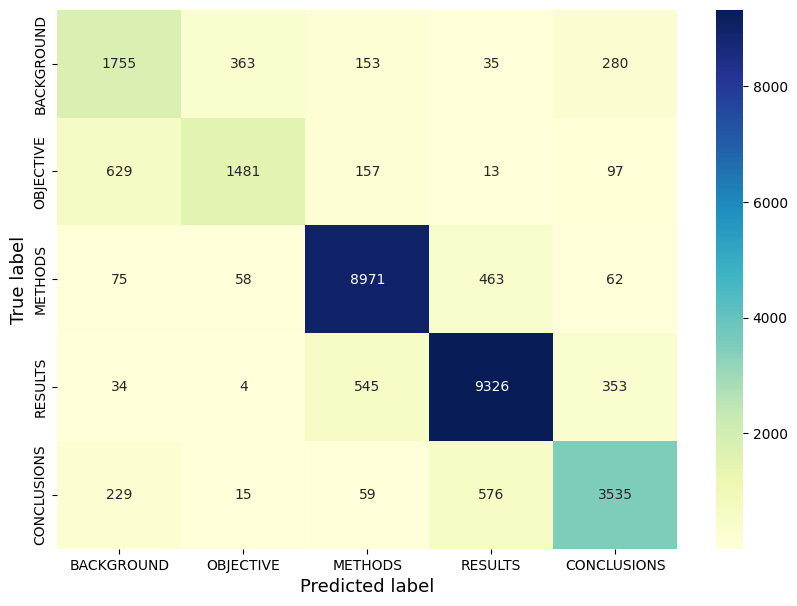

In [52]:
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index = [i for i in ['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS']],
                     columns = [i for i in ['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS']])
plt.figure(figsize = (10,7))
sn.heatmap(cm_df, cmap="YlGnBu", fmt='g', annot=True)
plt.xlabel('Predicted label',fontsize = 13)
plt.ylabel('True label',fontsize = 13)
plt.show()